# Underactuated cartpole control with iLQR, MPPI
This example shows model predictive control to swing up the underactuated cartpole.

![Underactuated cartpole control with iLQR](./cartpole-ilqr.gif)

## Problem

**Model.** The "cartpole" is a free pendulum on a linear cart.  The input to the system is a force on the cart $f$.

$$
m l \ddot{p} \cos(\theta) + m l^2 \ddot{\theta} - m g l \sin(\theta) = 0 \\
(m + m_c) \ddot{p} + m l \ddot{\theta} \cos(\theta) - m l \dot{\theta}^2 \sin(\theta) = f
$$
where $\theta = 0$ is the angle of the pendulum when completely upright, and $p$ is the position of the cart.  The state of the system is $x = (p, \theta, \dot{p}, \dot{\theta})^\top$.  Parameters are the mass of the pendulum at the tip $m = 0.15$ kg, length of the pendulum $l = 0.75$ m, acceleration due to gravity $g = 9.8$ m/s , and the mass of the cart $m_c=1$ kg.

**Control.** The objective is to move the cart so that the pendulum will stand up vertically.  This is a classic controls and RL problem and is a typical benchmark test for new algorithms.  We use the quadratic cost function

$$
J = \sum_{i=1}^{N} x_i^\top Q x_i + \sum_{i=1}^{N-1} r u_i^2
$$

where $Q = \text{diag}(1.25, 6, 12, 0.25)$ is chosen to drive the system states 0, and the penalty $r = 0.01$ tradeoffs the input magnitude.

**Comparison to MPPI.**  The video above shows iLQR which works well for this problem.  Examining MPPI (sampling-based control) in the video below, the algorithm seems to find a control that achieves the desired swing up behavior and temporarily stabilizes the system, however if the algorithm is left to run long enough, the system destabilizes and the controller is unable to maintain the upright posture.  This is believed due to a deficiency in the sampling approach as the noise in the control is amplified to attempt to maintain stability.

![Underactuated cartpole control with MPPI](./cartpole-mppi.gif)

## Example

To run the example, build and install the C++ and Python libraries from the main README instructions.  Start the docker container.
```
# Run the experiment
cd /libsia/bin
./example-cartpole --datafile /libsia/data/cartpole.csv --algorithm ilqr

# Run the python script
cd /libsia/examples/cartpole
python cartpole.py --help
python cartpole.py --datafile /libsia/data/cartpole.csv
```

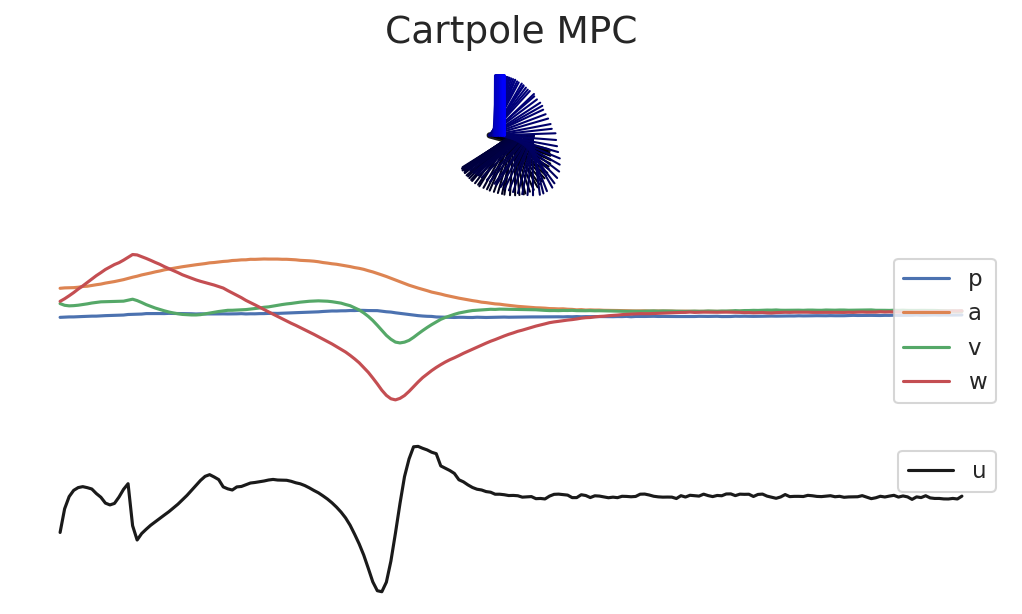

In [1]:
# This example imports data generated by the executable
from cartpole import plot_cartpole_trajectory

# This is the same as running the python script
plot_cartpole_trajectory(datafile="/libsia/data/cartpole.csv",
                         animate=False,
                         trace=True,
                         video_name="cartpole-animated.mp4",
                         dpi=150,
                         fps=30,
                         clean_axes=True)

## Learning from expert demonstration

[1] S. Schaal paper
[2] P. Owan thesis

Assume now we don't know the cartpole model.  We need to learn a model from data.  We use GMR
$$
\mathbb{E}[x_{k+1}] = f(x_k, u_k)
$$

State dimension is too high, compress it.
$$
z = \xi(x)
$$

Instead we do regression on the reduced space
$$
z_{k+1} = \hat{f}(z_k, u_k)
$$

Recover the state by plugging in to model
$$
x_{k+1} = \xi^{-1}(\hat{f}(\xi(x_k), u_k))
$$

In [2]:
import subprocess

num_trials = 20
datafiles = ["/libsia/data/cartpole-{}.csv".format(i) for i in range(num_trials)]

# Peform n trials with an expert policy
for datafile in datafiles:
    print("Running case {}".format(datafile))
    subprocess.call(["/libsia/bin/example-cartpole",
                     "--measurement_noise",
                     "1e-6",
                     "--process_noise",
                     "1e-6",
                     "--datafile", 
                     datafile])

Running case /libsia/data/cartpole-0.csv
Running case /libsia/data/cartpole-1.csv
Running case /libsia/data/cartpole-2.csv
Running case /libsia/data/cartpole-3.csv
Running case /libsia/data/cartpole-4.csv
Running case /libsia/data/cartpole-5.csv
Running case /libsia/data/cartpole-6.csv
Running case /libsia/data/cartpole-7.csv
Running case /libsia/data/cartpole-8.csv
Running case /libsia/data/cartpole-9.csv
Running case /libsia/data/cartpole-10.csv
Running case /libsia/data/cartpole-11.csv
Running case /libsia/data/cartpole-12.csv
Running case /libsia/data/cartpole-13.csv
Running case /libsia/data/cartpole-14.csv
Running case /libsia/data/cartpole-15.csv
Running case /libsia/data/cartpole-16.csv
Running case /libsia/data/cartpole-17.csv
Running case /libsia/data/cartpole-18.csv
Running case /libsia/data/cartpole-19.csv


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Time step at which the data was collected
dt = 0.02

# Load data and perform some analysis
df = pd.DataFrame()
for datafile in datafiles:
    df = df.append(pd.read_csv(datafile))
    
t = df["t"]
x = df[["p", "a", "v", "w"]].values
u = df["f"].values

# Run PCA on the state
n = 2
pca = PCA(n_components=n)
z = pca.fit_transform(x)
pca_pct = np.sum(pca.explained_variance_ratio_)
print("PCA with n={0:d} encodes {1:.4f}% of data".format(n, pca_pct))

# Stack the inputs and ouputs into X
uk = np.reshape(u[:-1], (len(u[:-1]), 1))
zk = z[:-1, :]
zkp1 = z[1:, :]
X = np.hstack((zk, uk, zkp1))

# Run GMM
import pysia as sia
gmm = sia.GMM(X.T, K=3, regularization=1e-6)

# Extract the means for visualization
means = np.zeros((gmm.numClusters(), gmm.dimension()))
for i in range(gmm.numClusters()):
    means[i,:] = gmm.gaussian(i).mean()

# Run GMR to condition z_kp1 on zk, uk
gmr = sia.GMR(gmm, input_indices=[0, 1, 2], output_indices=[3, 4])

PCA with n=2 encodes 0.9675% of data


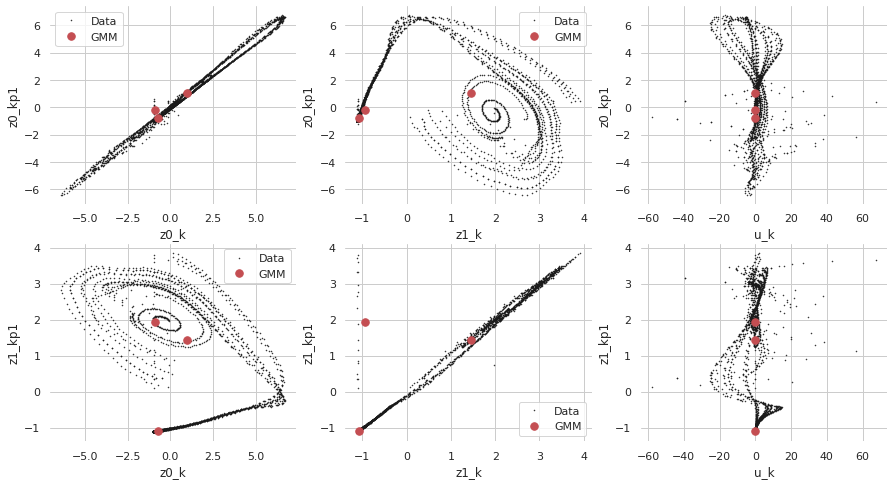

In [4]:
# Plot the probabilities
f, ax = plt.subplots(nrows=n, ncols=n+1, figsize=(15, 8))
sns.despine(f, left=True, bottom=True)

for i in range(n):
    for j in range(n):
        ax[i, j].plot(z[:-1, j], z[1:, i], ".k", ms=1, label="Data")
        ax[i, j].plot(means[:, j], means[:, i+3], ".r", ms=15, label="GMM")
        ax[i, j].set_ylabel("z{}_kp1".format(i))
        ax[i, j].set_xlabel("z{}_k".format(j))
        ax[i, j].legend()
    ax[i, n].plot(u[:-1], z[1:, i], ".k", ms=1)
    ax[i, n].plot(means[:, 2], means[:, i+3], ".r", ms=15)
    ax[i, n].set_ylabel("z{}_kp1".format(i))
    ax[i, n].set_xlabel("u_k".format(j))

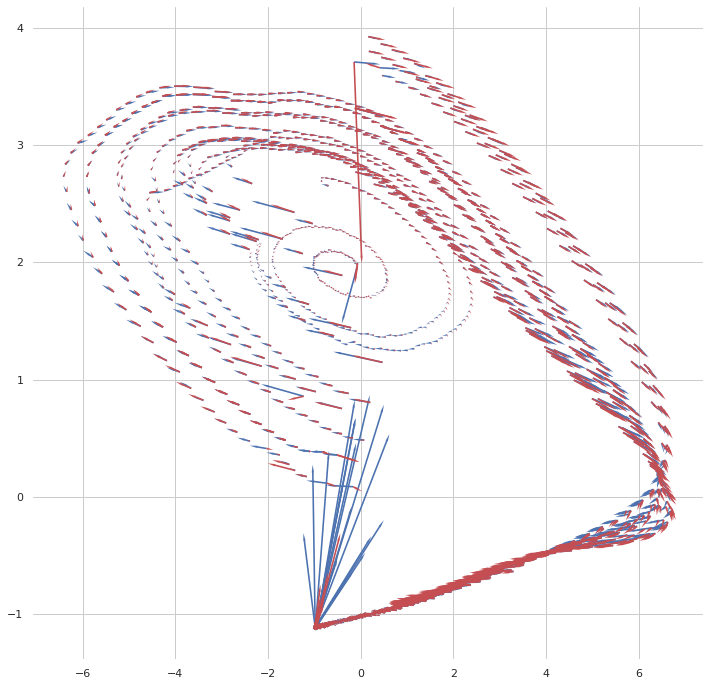

In [5]:
# Plot the vector field given inputs u
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
sns.despine(f, left=True, bottom=True)

ax.quiver(X[:, 0], 
          X[:, 1],
          (X[:, 3]-X[:, 0])/dt,
          (X[:, 4]-X[:, 1])/dt,
          color='b',
          headwidth=1.5)

Y = np.zeros((len(X), 2))
for i in range(len(X)):
    Y[i, :] = gmr.predict(X[i,:3]).mean()
ax.quiver(X[:, 0],
          X[:, 1],
          (Y[:, 0]-X[:, 0])/dt,
          (Y[:, 1]-X[:, 1])/dt,
          color='r',
          headwidth=1.5);